In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env_to_use = 0

discrete_actions = True

env = gym.make(envs[env_to_use]).unwrapped
if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001

In [2]:
def train_gan(pop,p_fitness,population_size,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        #print(pop.numel())
        ind = np.arange(population_size)
        np.random.shuffle(ind)
        pop = pop[ind]
        p_fitness = p_fitness[ind]
        for i in range(population_size//batch_size):
            #turn population into vectors
            p_batch = pop[i*batch_size:(i*batch_size)+batch_size].detach()
            f_batch = p_fitness[i*batch_size:(i*batch_size)+batch_size].detach()
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            
            dis_out_r,_ = dis(p_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            
            dis_error_real = (torch.pow((dis_out_r[...,0]-f_batch),2))
            dis_error_real_mean = torch.mean(dis_error_real)
            dis_error_real_mean.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.pow(dis_out_r[...,1]-dis_error_real.detach(),2))
            dis_confidence.backward()
            
            dis_optimizer.step() 
            dis_loss_all.append(dis_error_real_mean)  
            dis_confidence_all.append(torch.mean(dis_out_r[...,1]))
            
        #if False:
        for i in range(population_size//batch_size):
            gen_optimizer.zero_grad()
            gen_out = gen(p_batch.detach(),lr)
            dis_out_f,dis_out_latent = dis(p_batch + gen_out)
            
            #define generator loss
            variety = -torch.mean(torch.std(dis_out_latent,-1))
            
            gen_error_exploration = (variety)-torch.mean(dis_out_f[...,1])
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) 
            gen_error =  gen_error_exploitation + (gen_error_exploration)
            
            gen_error.backward()
            gen_optimizer.step() 
            
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            
    print(f_batch)
    print(dis_out_r[...,0])   
    
    return gen_explore_all,gen_exploit_all, dis_loss_all,dis_confidence_all

starting training
386
Measured population fitness : 0s
population fitness : [24. 10. 10. 10. 10.  9.  9.  9. 10. 10.]
mean fit : 11.1
tensor([-0.4858, -0.4858, -0.2544, -0.2544, -0.4858, -0.2544, -0.2544, -0.2544,
        -0.2544,  2.9839], device='cuda:0')
tensor([-0.3640, -0.4572, -0.2106, -0.2558, -0.4740, -0.2639, -0.1098, -0.2619,
        -0.2862,  2.6868], device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


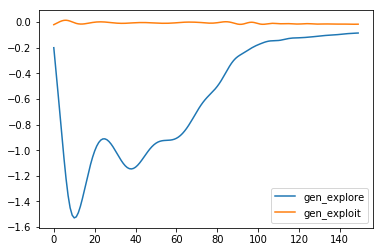

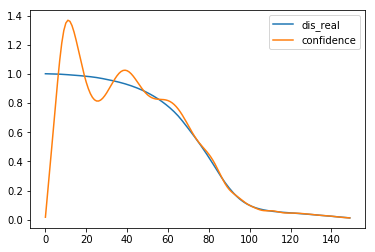

Generation 1  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [42. 10.  9.  9. 10. 10.  9. 13.  9. 10.]
mean fit : 13.1
tensor([-0.2772,  3.9469,  1.5708, -0.4092, -0.2772, -0.4092, -0.2772, -0.2772,
        -0.2772, -0.2772, -0.4092, -0.4092, -0.2772, -0.2772, -0.4092,  0.1188,
        -0.2772, -0.4092, -0.2772, -0.4092], device='cuda:0')
tensor([-0.2721,  2.7494,  2.7494, -0.4115, -0.3433, -0.3559, -0.3559, -0.2840,
        -0.3353, -0.3544, -0.4115, -0.3353, -0.2721, -0.2840, -0.3544, -0.1502,
        -0.2840, -0.1502, -0.2840, -0.3433],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


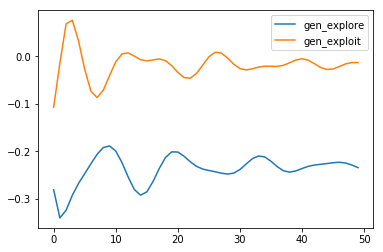

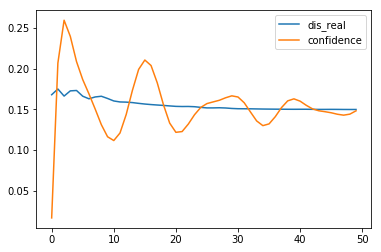

Generation 2  fitness : 42.0
#################################
Measured population fitness : 0s
population fitness : [23. 10.  9. 10.  9.  9.  9.  9. 10. 10.]
mean fit : 10.8
tensor([-0.4010, -0.2506, -0.2506, -0.4010, -0.4010, -0.4010,  0.2005, -0.2506,
        -0.4010, -0.2506, -0.4010, -0.2506, -0.2506,  1.7043, -0.4010, -0.4010,
        -0.2506,  4.5614, -0.4010, -0.2506], device='cuda:0')
tensor([-0.3193, -0.2440, -0.3226, -0.3973, -0.3226, -0.3973, -0.0992, -0.3193,
        -0.3320, -0.2440, -0.4027, -0.2430, -0.3320,  3.1241, -0.4027, -0.0992,
        -0.2430,  3.1241, -0.3207, -0.3207],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


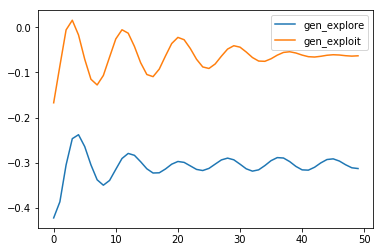

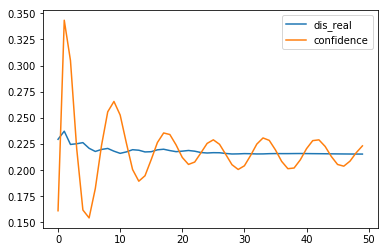

Generation 3  fitness : 23.0
#################################
Measured population fitness : 0s
population fitness : [30.  9.  9.  9.  9. 10.  9.  9.  9.  9.]
mean fit : 11.2
tensor([-0.2362, -0.3887,  2.8120, -0.3887, -0.3887, -0.3887, -0.2362, -0.3887,
        -0.2362, -0.3887, -0.3887, -0.3887, -0.2362, -0.3887,  1.7451, -0.2362,
        -0.3887, -0.3887, -0.3887, -0.3887], device='cuda:0')
tensor([-0.3149, -0.3837,  2.2198, -0.3802, -0.3130, -0.3822, -0.3174, -0.3822,
        -0.2999, -0.2999, -0.3635, -0.3802, -0.3130, -0.3088,  2.2198, -0.3088,
        -0.3837, -0.3174, -0.3635, -0.3149],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


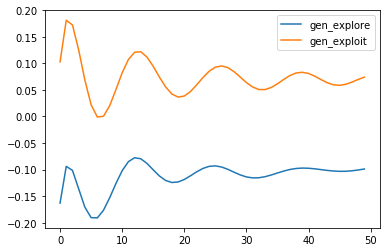

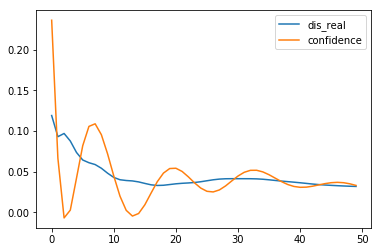

Generation 4  fitness : 30.0
#################################
Measured population fitness : 0s
population fitness : [33.  9. 10. 10.  9.  9.  9.  9. 10.  9.]
mean fit : 11.7
tensor([-0.3865, -0.3865, -0.3865, -0.3865, -0.2367, -0.3865, -0.3865, -0.3865,
         3.2087,  2.7593, -0.2367, -0.3865, -0.3865, -0.2367, -0.3865, -0.3865,
        -0.2367, -0.3865, -0.3865, -0.3865], device='cuda:0')
tensor([-0.3038, -0.3006, -0.3827, -0.3864, -0.3006, -0.3801, -0.3822, -0.3811,
         2.9829,  2.9829, -0.3052, -0.3811, -0.3864, -0.2965, -0.3827, -0.3052,
        -0.3038, -0.2965, -0.3822, -0.3801],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


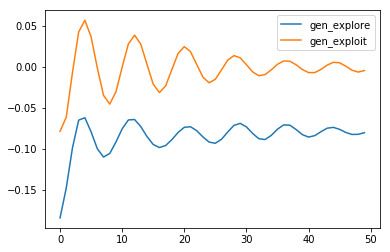

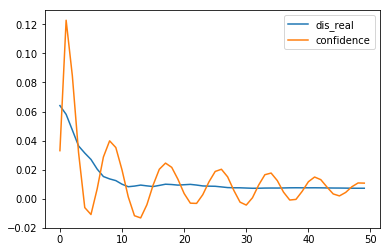

Generation 5  fitness : 33.0
#################################
Measured population fitness : 0s
population fitness : [34. 10. 10. 10. 10. 10.  9.  9.  9. 10.]
mean fit : 12.1
tensor([-0.3928, -0.2455, -0.2455, -0.3928, -0.3928, -0.2455, -0.3928, -0.3928,
        -0.2455, -0.2455,  3.2897, -0.3928, -0.3928,  3.1424, -0.2455, -0.2455,
        -0.2455, -0.3928, -0.2455, -0.3928], device='cuda:0')
tensor([-0.3283, -0.2508, -0.3273, -0.3225, -0.3217, -0.3214, -0.3214, -0.4025,
        -0.3225, -0.2508,  3.2179, -0.3993, -0.4025,  3.2179, -0.2484, -0.3283,
        -0.2484, -0.3993, -0.3217, -0.3273],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


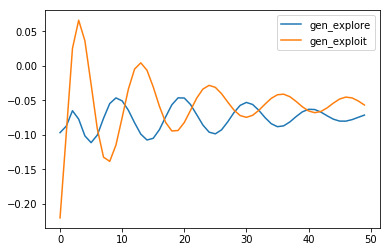

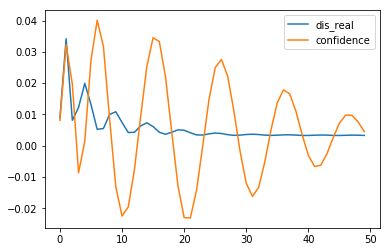

Generation 6  fitness : 34.0
#################################
Measured population fitness : 0s
population fitness : [86. 10.  9.  9. 10. 10.  8. 15.  9. 10.]
mean fit : 17.6
tensor([-0.3228, -0.3228, -0.2309, -0.2309, -0.3228, -0.2309,  6.7496,  1.9734,
        -0.2309, -0.2309,  0.2283, -0.2309, -0.4146, -0.2309, -0.2309, -0.2309,
        -0.3228, -0.3228, -0.3228, -0.2309], device='cuda:0')
tensor([-0.3947, -0.3947, -0.3855, -0.2707, -0.3587, -0.3484,  5.5313,  5.5313,
        -0.3545, -0.3908, -0.1803, -0.3545, -0.4572, -0.3587, -0.3484, -0.3908,
        -0.3855, -0.4572, -0.1803, -0.2707],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


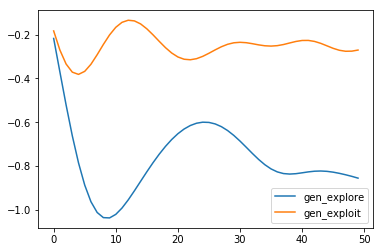

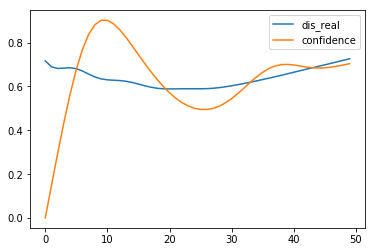

Generation 7  fitness : 86.0
#################################
Measured population fitness : 0s
population fitness : [44.  9.  9. 10. 11. 10. 10. 10. 10. 10.]
mean fit : 13.3
tensor([-0.2416,  6.7872, -0.2416,  0.2208, -0.3341, -0.1491, -0.2416, -0.3341,
         2.9029, -0.3341, -0.2416, -0.3341, -0.2416, -0.2416, -0.2416, -0.4266,
        -0.3341, -0.2416, -0.2416, -0.2416], device='cuda:0')
tensor([-0.2655,  4.8286, -0.3640,  0.0008, -0.3003, -0.2543, -0.2931, -0.2655,
         4.8286, -0.3003, -0.2730, -0.2931, -0.2242, -0.2012, -0.2543, -0.3640,
        -0.2730,  0.0008, -0.2242, -0.2012],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


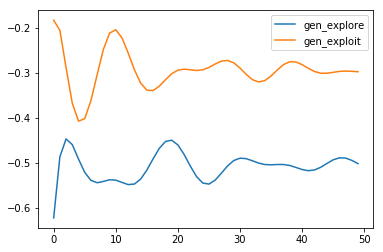

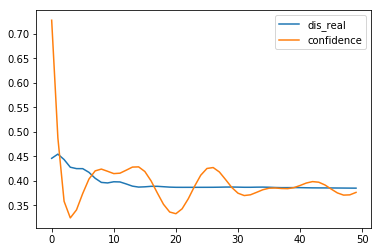

Generation 8  fitness : 44.0
#################################
Measured population fitness : 0s
population fitness : [62. 10. 11. 10. 10.  9. 10. 16. 10.  9.]
mean fit : 15.7
tensor([-0.2575, -0.2575, -0.3446, -0.2575, -0.2575,  4.2731, -0.1704, -0.2575,
        -0.2575, -0.3446, -0.1704,  0.2653, -0.2575, -0.2575, -0.2575, -0.3446,
        -0.2575, -0.2575,  2.7048, -0.3446], device='cuda:0')
tensor([ 0.0163, -0.2568, -0.2250, -0.2406, -0.2075,  3.3046, -0.2075, -0.2406,
        -0.2434, -0.2592, -0.2250,  0.0163, -0.2434, -0.2568, -0.2592, -0.2640,
        -0.2640, -0.2572,  3.3046, -0.2572],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


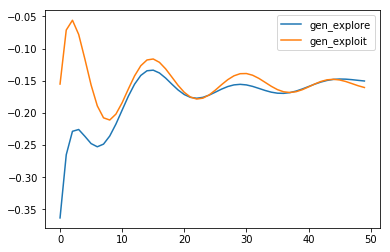

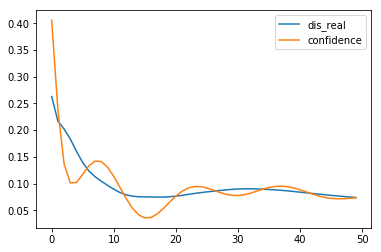

Generation 9  fitness : 62.0
#################################
Measured population fitness : 0s
population fitness : [31. 10. 10.  9.  9. 10. 10. 11.  9.  8.]
mean fit : 11.7
tensor([-0.2553, -0.3455, -0.3455,  0.2859, -0.4357, -0.2553, -0.2553, -0.3455,
        -0.2553, -0.2553,  1.6390,  4.4353, -0.3455, -0.2553, -0.2553, -0.2553,
        -0.1651, -0.3455, -0.2553, -0.1651], device='cuda:0')
tensor([-0.2632, -0.2979, -0.3789,  0.0585, -0.3789, -0.2114, -0.2979, -0.2992,
        -0.2586, -0.3118,  3.0054,  3.0054, -0.3118, -0.2995, -0.2586, -0.2632,
        -0.2114, -0.2995, -0.2992,  0.0585],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


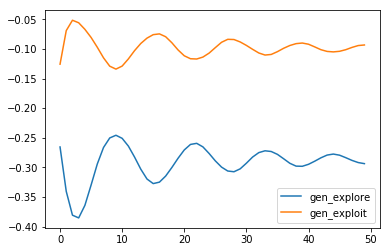

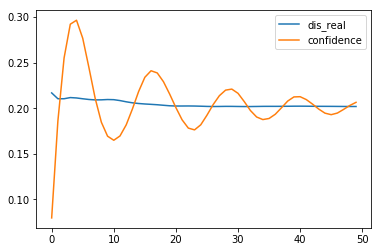

Generation 10  fitness : 31.0
#################################
Measured population fitness : 0s
population fitness : [37. 11.  8.  9.  8.  9. 10. 15. 10.  9.]
mean fit : 12.6
tensor([-0.3505, -0.2585, -0.3505, -0.3505, -0.4426,  2.2262,  1.6740, -0.1665,
        -0.4426, -0.1665,  0.2016, -0.2585, -0.2585, -0.4426, -0.3505, -0.2585,
        -0.2585, -0.2585, -0.3505, -0.3505], device='cuda:0')
tensor([-0.3119, -0.2173, -0.3522, -0.3592, -0.3592,  1.8404,  1.8404, -0.2173,
        -0.2980, -0.0097, -0.0097, -0.2908, -0.2805, -0.3522, -0.2805, -0.2980,
        -0.2561, -0.2561, -0.2908, -0.3119],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


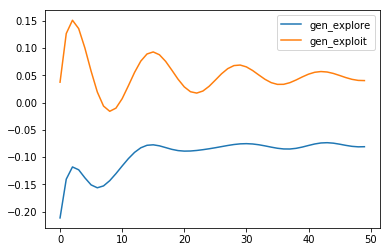

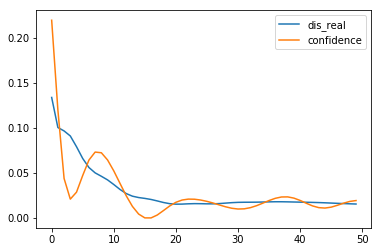

Generation 11  fitness : 37.0
#################################
Measured population fitness : 0s
population fitness : [57. 10.  8.  9. 10. 10.  8. 12.  8.  9.]
mean fit : 14.1
tensor([-0.3496, -0.4388, -0.2603, -0.3496,  0.1859, -0.2603, -0.3496, -0.4388,
        -0.0818, -0.4388, -0.3496, -0.4388, -0.3496,  3.9347, -0.2603, -0.1711,
        -0.2603,  2.1496, -0.4388, -0.2603], device='cuda:0')
tensor([-0.3335, -0.4406, -0.3366, -0.3335,  0.0405, -0.2082, -0.3019, -0.4406,
         0.0405, -0.3469, -0.3450, -0.3366, -0.3450,  3.0143, -0.3436, -0.2082,
        -0.3469,  3.0143, -0.3436, -0.3019],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


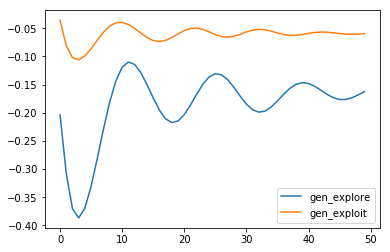

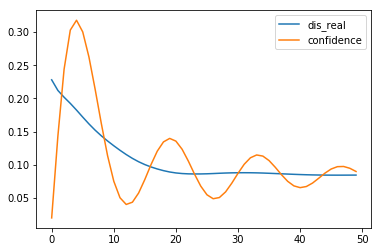

Generation 12  fitness : 57.0
#################################
Measured population fitness : 0s
population fitness : [32. 10.  9. 10.  8.  9. 10. 14.  9.  9.]
mean fit : 12.0
tensor([ 1.7519, -0.2603, -0.3518, -0.3518, -0.3518, -0.0774, -0.4433, -0.2603,
        -0.2603, -0.3518, -0.4433,  0.1055, -0.2603, -0.3518,  4.0386, -0.4433,
        -0.2603, -0.3518, -0.4433, -0.2603], device='cuda:0')
tensor([ 2.8996, -0.3510, -0.3085, -0.3986, -0.3525,  0.0182, -0.3510, -0.3085,
        -0.3021, -0.3525, -0.3527,  0.0182, -0.2613, -0.3969,  2.8996, -0.3969,
        -0.2613, -0.3021, -0.3986, -0.3527],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


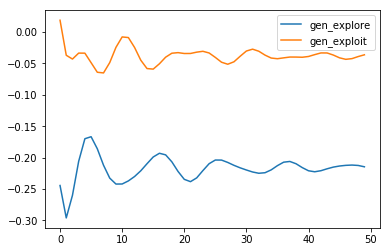

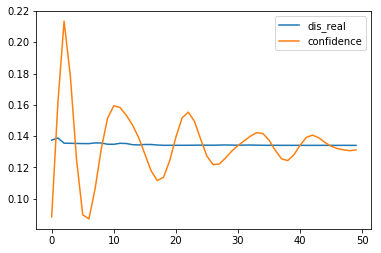

Generation 13  fitness : 32.0
#################################
Measured population fitness : 0s
population fitness : [19.  9.  8.  9.  9. 10.  9. 26.  9.  9.]
mean fit : 11.7
tensor([-0.3536, -0.2596, -0.3536, -0.3536, -0.3536, -0.3536, -0.2596, -0.3536,
        -0.3536, -0.3536,  1.2432, -0.4475, -0.2596, -0.3536, -0.3536, -0.4475,
         1.8067,  0.5857,  0.1161, -0.2596], device='cuda:0')
tensor([-0.2884, -0.2884, -0.2429, -0.3182, -0.2989, -0.2581, -0.2865, -0.2581,
        -0.2989, -0.2517,  0.3169, -0.3182, -0.2517, -0.2865, -0.3397, -0.3397,
         1.1557,  1.1557,  0.3169, -0.2429],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


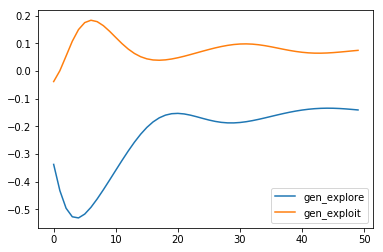

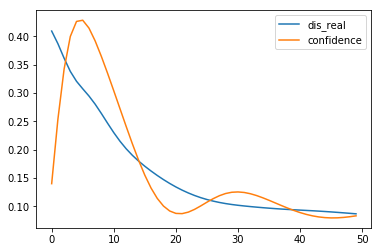

Generation 14  fitness : 26.0
#################################
Measured population fitness : 0s
population fitness : [15. 10. 10.  9.  9.  8. 10. 14.  9.  9.]
mean fit : 10.3
tensor([-0.2519,  0.2326, -0.3489, -0.3489, -0.4458,  1.2985,  0.1357, -0.3489,
        -0.2519, -0.3489, -0.3489, -0.3489,  0.6202, -0.4458, -0.3489, -0.3489,
        -0.2519, -0.2519, -0.3489, -0.3489], device='cuda:0')
tensor([-0.3482,  0.4462, -0.3477, -0.3477, -0.3656,  0.6912,  0.6912, -0.3471,
        -0.3656, -0.2996, -0.3020, -0.3511,  0.4462, -0.3482, -0.3549, -0.3549,
        -0.3020, -0.2996, -0.3511, -0.3471],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


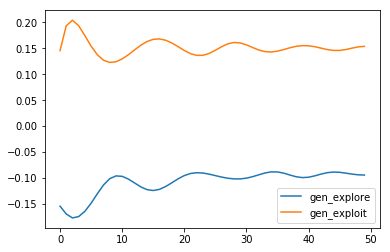

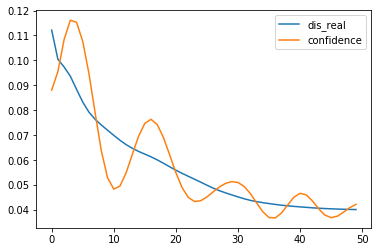

Generation 15  fitness : 15.0
#################################
Measured population fitness : 0s
population fitness : [20.  8. 10.  9. 10.  8.  9. 11.  9. 10.]
mean fit : 10.4
tensor([-0.2453, -0.4445, -0.2453, -0.2453,  0.1531, -0.3449, -0.3449, -0.3449,
         0.7507, -0.3449, -0.3449, -0.3449, -0.2453, -0.2453, -0.3449,  0.2527,
        -0.2453, -0.1457, -0.4445, -0.4445], device='cuda:0')
tensor([-0.3243, -0.3324, -0.2927, -0.3324,  0.0431, -0.3072, -0.3451, -0.3509,
         0.5035, -0.3243, -0.3451, -0.2927, -0.2823, -0.2823, -0.3509,  0.5035,
        -0.3072,  0.0431, -0.4099, -0.4099],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


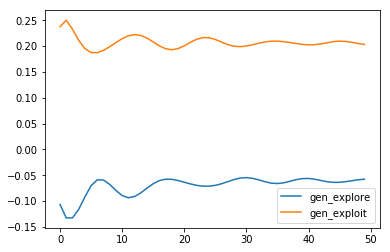

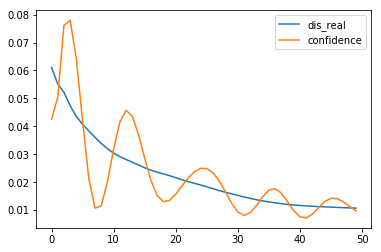

Generation 16  fitness : 20.0
#################################
Measured population fitness : 0s
population fitness : [21.  8.  8. 10.  9. 10.  9. 14. 11.  9.]
mean fit : 10.9
tensor([-0.3443, -0.3443, -0.3443, -0.2421, -0.4464,  0.7793, -0.1400, -0.3443,
        -0.3443, -0.2421, -0.2421,  0.1664, -0.2421,  0.8814, -0.1400, -0.4464,
        -0.2421, -0.3443, -0.4464, -0.4464], device='cuda:0')
tensor([-0.3480, -0.3480, -0.2997, -0.3455, -0.4497,  0.8341, -0.2431, -0.2431,
        -0.2907, -0.2997, -0.3401,  0.0083, -0.2932,  0.8341,  0.0083, -0.4497,
        -0.2907, -0.2932, -0.3401, -0.3455],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


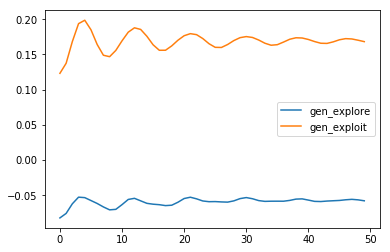

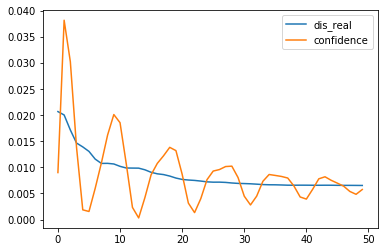

Generation 17  fitness : 21.0
#################################
Measured population fitness : 0s
population fitness : [16.  9.  8. 11. 10. 11. 10. 10.  8.  9.]
mean fit : 10.2
tensor([-0.1310, -0.2358,  0.3930, -0.4454, -0.3406, -0.3406, -0.4454, -0.1310,
         0.9171, -0.2358, -0.2358, -0.4454, -0.1310, -0.2358, -0.2358, -0.4454,
        -0.3406, -0.3406, -0.3406,  0.1834], device='cuda:0')
tensor([-0.2904, -0.2898,  0.6570, -0.2904, -0.3437, -0.3437, -0.4511, -0.1805,
         0.6570, -0.0234, -0.2879, -0.4511, -0.1795, -0.1805, -0.1795, -0.3922,
        -0.2879, -0.2898, -0.3922, -0.0234],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


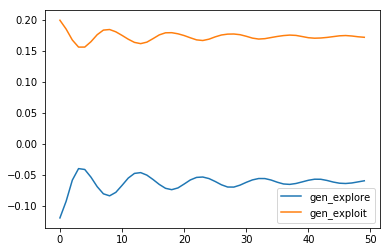

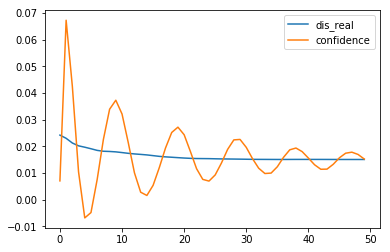

Generation 18  fitness : 16.0
#################################
Measured population fitness : 0s
population fitness : [22.  9. 10. 10.  8.  9. 10. 11.  9.  9.]
mean fit : 10.7
tensor([-0.2323, -0.1252, -0.3394, -0.1252, -0.3394, -0.4465, -0.3394, -0.3394,
        -0.3394, -0.4465, -0.2323, -0.1252, -0.3394, -0.2323, -0.4465, -0.2323,
         1.0532,  0.4105, -0.2323, -0.2323], device='cuda:0')
tensor([-0.3389, -0.1775, -0.2366, -0.1882, -0.3908, -0.3908, -0.3429, -0.3446,
        -0.3429, -0.3425, -0.1775, -0.2366, -0.3446, -0.2338, -0.3389, -0.1882,
         0.7291,  0.7291, -0.3425, -0.2338],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


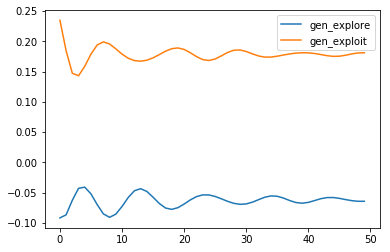

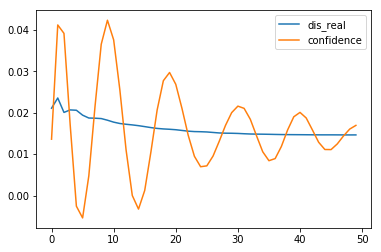

Generation 19  fitness : 22.0
#################################
Measured population fitness : 0s
population fitness : [27. 10.  9.  9. 10.  8.  9. 12.  8. 10.]
mean fit : 11.2
tensor([-0.0131, -0.2309, -0.2309, -0.4488, -0.3399, -0.3399, -0.1220, -0.2309,
         1.6209, -0.4488, -0.4488, -0.3399, -0.3399, -0.3399, -0.3399, -0.2309,
         1.0762, -0.3399, -0.2309, -0.2309], device='cuda:0')
tensor([-0.0655, -0.2726, -0.2783, -0.3868, -0.2726, -0.3920, -0.0655, -0.2783,
         1.3265, -0.3920, -0.3383, -0.2783, -0.2783, -0.2739, -0.2809, -0.2809,
         1.3265, -0.3868, -0.2739, -0.3383],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


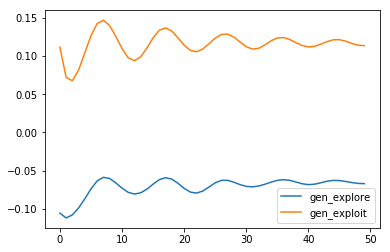

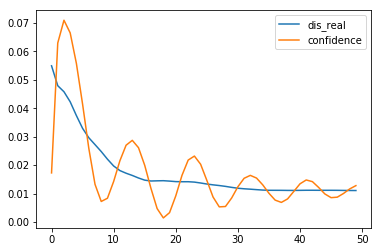

Generation 20  fitness : 27.0
#################################
Measured population fitness : 0s
population fitness : [19.  9.  9. 10. 10. 10. 11.  9.  9. 10.]
mean fit : 10.6
tensor([-0.0053, -0.2279, -0.3391, -0.2279,  1.6638, -0.2279, -0.2279, -0.3391,
        -0.2279, -0.4504, -0.1166, -0.3391, -0.4504,  0.7736, -0.3391, -0.2279,
        -0.2279, -0.3391, -0.3391, -0.3391], device='cuda:0')
tensor([-0.1721, -0.3407, -0.2842, -0.2847,  1.2267, -0.2284, -0.2258, -0.1721,
        -0.2284, -0.3964, -0.2271, -0.2271, -0.3407,  1.2267, -0.3414, -0.2842,
        -0.2258, -0.3414, -0.3964, -0.2847],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


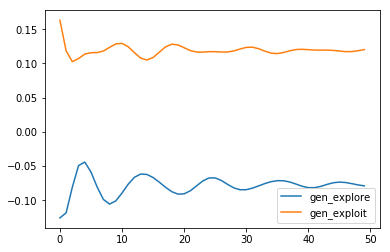

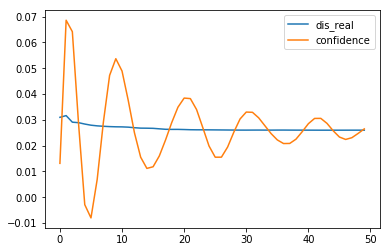

Generation 21  fitness : 19.0
#################################
Measured population fitness : 0s
population fitness : [16.  8.  9.  9.  9. 10.  8. 10. 10.  8.]
mean fit : 9.7
tensor([ 0.4609, -0.2204, -0.3339, -0.4475, -0.4475, -0.3339, -0.2204,  0.8016,
        -0.1068, -0.3339, -0.3339, -0.2204, -0.2204, -0.2204, -0.2204, -0.3339,
        -0.3339, -0.2204, -0.3339, -0.4475], device='cuda:0')
tensor([ 0.6575, -0.3114, -0.2742, -0.2685, -0.3549, -0.3549, -0.2919,  0.6575,
        -0.2685, -0.2877, -0.3161, -0.3161, -0.2566, -0.2566, -0.2877, -0.2919,
        -0.3345, -0.2742, -0.3345, -0.3114],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


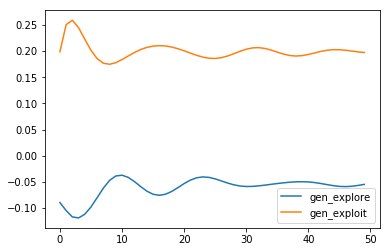

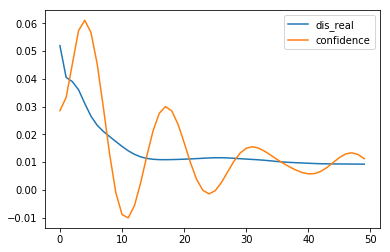

Generation 22  fitness : 16.0
#################################
Measured population fitness : 0s
population fitness : [17.  9.  9. 10.  9. 10. 10. 10. 10.  9.]
mean fit : 10.3
tensor([-0.2166, -0.2166, -0.4482, -0.2166, -0.2166,  0.5943, -0.4482, -0.3324,
        -0.2166,  0.4785, -0.3324, -0.2166, -0.2166, -0.3324, -0.4482, -0.3324,
        -0.2166, -0.3324, -0.3324, -0.3324], device='cuda:0')
tensor([-0.2765, -0.2147, -0.3327, -0.3327, -0.2204,  0.5429, -0.3932, -0.3395,
        -0.2204,  0.5429, -0.3928, -0.2147, -0.2125, -0.3932, -0.3928, -0.3306,
        -0.2125, -0.3306, -0.2765, -0.3395],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


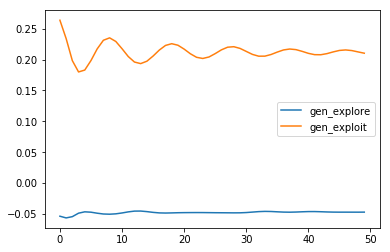

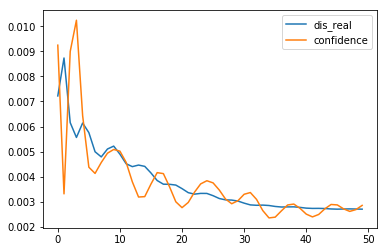

Generation 23  fitness : 17.0
#################################
Measured population fitness : 0s
population fitness : [16.  9.  8. 10. 10. 10.  8. 12. 10.  9.]
mean fit : 10.2
tensor([-0.2125, -0.2125, -0.4487, -0.2125, -0.3306, -0.4487,  0.4959,  0.6140,
        -0.3306, -0.3306,  0.0236, -0.3306, -0.2125, -0.2125, -0.2125, -0.2125,
        -0.3306, -0.3306, -0.2125, -0.2125], device='cuda:0')
tensor([-0.2162, -0.2140, -0.3986, -0.3332, -0.3284, -0.3332,  0.5490,  0.5490,
        -0.2704, -0.3284, -0.0932, -0.3314, -0.0932, -0.2129, -0.2140, -0.2162,
        -0.3986, -0.3314, -0.2129, -0.2704],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


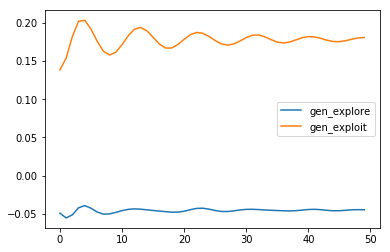

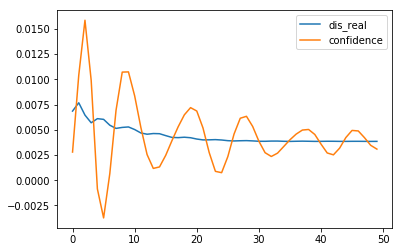

Generation 24  fitness : 16.0
#################################
Measured population fitness : 0s
population fitness : [22.  9. 10.  8.  9.  8. 10.  9.  9.  9.]
mean fit : 10.3
tensor([-0.4484, -0.3285, -0.2086, -0.4484, -0.2086,  1.2300,  0.5107,  0.0312,
        -0.2086, -0.2086, -0.3285, -0.3285, -0.3285, -0.2086, -0.3285, -0.3285,
        -0.4484, -0.3285, -0.4484, -0.2086], device='cuda:0')
tensor([-0.3359, -0.3237, -0.3359, -0.3176, -0.3176,  0.8680,  0.8680, -0.1522,
        -0.3377, -0.2652, -0.3230, -0.2652, -0.3230, -0.2720, -0.1522, -0.2720,
        -0.3256, -0.3237, -0.3377, -0.3256],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


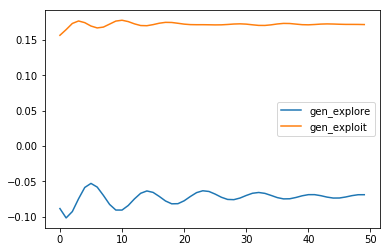

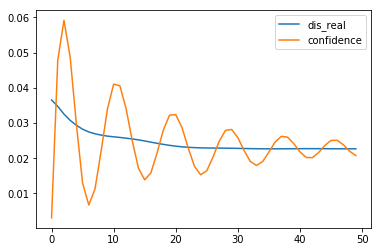

Generation 25  fitness : 22.0
#################################
Measured population fitness : 0s
population fitness : [22.  9.  9.  9. 10.  9.  9. 10.  9. 10.]
mean fit : 10.6
tensor([-0.3281, -0.2064, -0.4498, -0.3281, -0.3281, -0.2064, -0.3281, -0.3281,
         1.2540, -0.3281, -0.2064, -0.3281, -0.3281, -0.3281, -0.2064, -0.3281,
        -0.3281, -0.4498,  1.2540, -0.2064], device='cuda:0')
tensor([-0.3249, -0.2703, -0.3912, -0.2593, -0.3912, -0.2591, -0.2703, -0.2613,
         1.2585, -0.3249, -0.2593, -0.2656, -0.3909, -0.2591, -0.2613, -0.3295,
        -0.3295, -0.3909,  1.2585, -0.2656],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


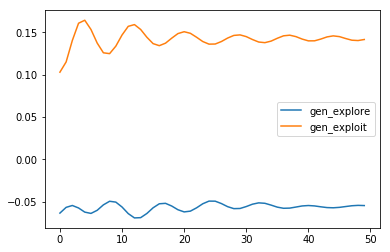

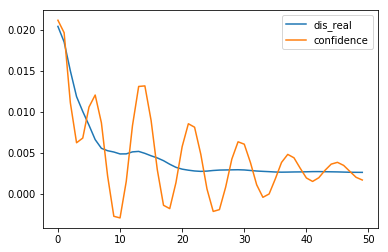

Generation 26  fitness : 22.0
#################################
Measured population fitness : 0s
population fitness : [24. 10. 11. 10. 10. 10. 11.  9. 10.  9.]
mean fit : 11.4
tensor([-0.3313, -0.3313,  1.5195, -0.2079, -0.3313, -0.3313,  1.2727, -0.3313,
        -0.3313, -0.0845, -0.2079, -0.2079, -0.2079, -0.3313, -0.2079, -0.2079,
        -0.0845, -0.2079, -0.2079, -0.3313], device='cuda:0')
tensor([-0.2695, -0.2114,  1.3931, -0.2766, -0.2705, -0.2679,  1.3931, -0.2738,
        -0.2114, -0.2114, -0.2102, -0.2695, -0.2679, -0.2766, -0.2102, -0.2738,
        -0.2114, -0.2705, -0.2706, -0.2706],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 0s


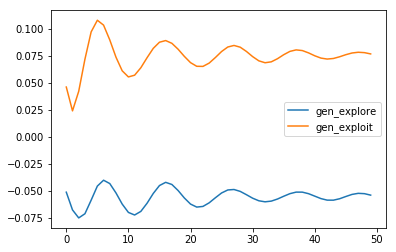

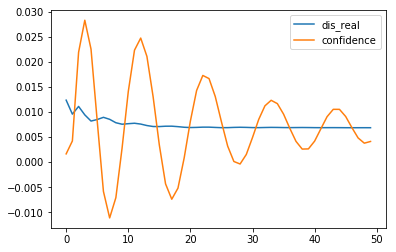

Generation 27  fitness : 24.0
#################################
Measured population fitness : 0s
population fitness : [23. 10.  9.  9.  8.  8. 10.  8.  9.  8.]
mean fit : 10.2


In [ ]:
population = []
max_population_batch = 2
n_generations = 300
population_size = 10

for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    creat = set_params(creat,pars)
    population.append(creat)
    
print("starting training")
creature_size = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
print(creature_size)

old_population = []
old_fitnesses = []
all_fitnesses = []

gen = Generator(creature_size,device).to(device)
dis = Discriminator().to(device)


for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0001,betas=(0.9,0.999))
    
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))   
    
    #define population batch
    population_concat = np.concatenate(np.array(old_population))
    population_batch = []
    for p in population_concat:
        #print(get_params(p))
        population_batch.append(get_params(p))
    population_batch = torch.stack(population_batch, dim=0).to(device)
    
    #define fitness batch
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    fitness_batch_normed = ((fitness_batch - np.mean(all_fitnesses))/np.std(all_fitnesses))
    
    #Train GAN
    start_time = time.time()
    n_epochs = 50
    if i == 0:
        n_epochs = 150
        
    gen_explore_all,gen_exploit_all, dis_loss ,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              fitness_batch.size,batch_size =fitness_batch.size,n_epochs = n_epochs)
    
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
        
    
    #print(population_batch[population_batch.size(0)  - population_size:].shape,population_batch.shape)
    mutations = gen(population_batch[population_batch.size(0)  - population_size:],lr)
    #Apply mutations
    
    for idx,p in enumerate(population_batch[population_batch.size(0) - population_size:]):
        child = Creature(env.observation_space.shape[0],creature_out_size) 
        population[idx] = set_params(child,p + mutations[idx])
    
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")